## Running Performance Classification Project

**1. Problem Statement**
- **Objective:** Classify runners into performance tiers (Beginner / Intermediate / Advanced) based on running metrics. Compare between Clustering to true labels.

---

**2. Data Collection**
- Based on friends' running data (Garmin Connect, RunKeeper, Apple Watch, Nike run club, Strava).
- Kaggle - "Running Log Insight," "Running races from Strava," "strava-data."
- **Limitations:** Small datasets (~280 runners overall).

---

**3. Method**
- Gather the datasets and create a median run for each runner, then use the chosen running metric and run the model.
- Using Riegel formula - [https://trainasone.com/ufaq/riegels-formula/](https://trainasone.com/ufaq/riegels-formula/) to create a custom running metric.
- Splitting the data to train and test by using `traintestsplit` function (splits randomly the data to train split and test split, sizes can be determine by the user) and Cross Validation (divides the data to multiple 'folds', every time using different 'fold' as the test split and running the model than aggregate the model results and returns their average).
- **Classification models:** Decision Tree, Logistic Regression, Random Forest, Gradient Boosting.
- **Clustering model:** K-means.

---

**4. Measuring Model Performance**
- **Common classification metrics:**
    - **Accuracy:** Measures the ratio of True classifications.
      Formula: $(TP + TN) / (TP + TN + FP + FN)$
    - **Precision:** Measures the ratio of True Positive out of all the positive classifications in the model.
      Formula: $TP / (TP + FP)$
    - **Recall:** Measures the ratio of True Positive out of all real positives.
      Formula: $TP / (TP + FN)$
    - **F1 Score:** Harmonic mean of its precision and recall, providing a single value that balances both.
      Formula: $2 * (Precision * Recall) / (Precision + Recall)$
- **Decision Tree metrics:**
    - **Gini:** Measures the impurity of data within a decision tree node. When 0, the node is pure (contains only elements of a single class). Higher values mean the node is impure (has a more mixed distribution of classes).
- **Classification Summaries:**
    - **Support:** Number of actual occurrences of the class in the specified dataset.
    - **Macro Avg:** The unweighted average of the per-class metrics. It calculates the metric for each class and then takes a simple arithmetic mean.
    - **Weighted Avg:** The average of the per-class metrics, weighted by the support for each class.
- **Common Clustering metrics:**
    - **Internal Clustering Validation Metrics:**
        - **Inertia:** The sum of the squared distances between each data point and the centroid of its assigned cluster. It measures how 'tight' or 'compact' the cluster is. A lower inertia value indicates that the data points are closer to their cluster centroids, meaning the clusters are more dense and well-defined. As you increase the number of clusters (K), the inertia will always decrease because each point will be closer to a centroid.
        - **Davies-Bouldin score:** The average similarity measure of each cluster with its most similar cluster. Similarity is measured as a ratio of within-cluster distances to between-cluster distances. A lower score is better and the minimum score is 0. A lower score indicates that the clusters are more compact and better separated from each other.
        - **Silhouette score:** Provides a more formal way to evaluate the quality of your clustering. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score is calculated for each data point and then averaged. The score range is between (-1, 1), where 1 means the data point is well-matched to its own cluster and well-separated from neighboring clusters; 0 means the data point is on or very close to the decision boundary between two clusters; and -1 means the data point is likely assigned to the wrong cluster.
        - **Calinski-Harabasz Index** (Variance Ratio Criterion): This score is a ratio of the between-cluster dispersion mean and the within-cluster dispersion mean. A higher score is better, as it shows that the clusters are dense and well separated.
    - **External Clustering Validation Metrics:** These are used when you have a dataset with known class labels and you want to see how well your clustering algorithm can recreate those classes.
        - **Adjusted Rand Index (ARI):** Measures the similarity between two clusterings (your predicted clusters and the true labels), while the "Adjusted" version corrects for chance. The score ranges from -1 to 1. A score of 1 indicates perfect agreement. A score of 0 indicates a random assignment. A negative score indicates that the assignment was even worse than random assignment.
        - **Homogeneity:** Measures if each cluster contains only data points of a single class.
        - **Completeness:** Measures if all data points of a given class are in the same cluster.
        - **V-measure:** The harmonic mean of homogeneity and completeness, providing a single score that balances both. The score ranges from 0 to 1, with 1 being the best. These metrics are based on conditional entropy.

---

**5. Sensitivity**
- The model performs a relative classification, meaning it categorizes runners into performance tiers (Beginner / Intermediate / Advanced) based on their results relative to all other runners present in the specific dataset being analyzed.
- Key Implication: A single runner may be classified into different performance tiers when analyzed using different datasets, as the tier assignment is entirely dependent on the competitive distribution of the data.
- Because there is no true predictor, I used the Reigel formula which is calculated from pace and distance, I combined it with average heart rate to create a matrix called GRPS.
However, this matrix depends heavily on the calculated pace, which means that classification models may try to “reverse-engineer” the formula instead of learning meaningful patterns.  
In real-world data, we would prefer to classify performance based on ground-truth labels, such as race results or a coach’s assessment. Therefore, we will build an experimental model that excludes the calculated pace from its feature set.

In [36]:
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import sys

sys.path.append(os.getcwd())
import utils

print("✅ All libraries are working!")


✅ All libraries are working!


In [38]:
maor = pd.read_csv("../data/maor's_data.csv")
ely = pd.read_excel("../data/Ely's_data(no_HR).xlsx")
shapira = pd.read_excel("../data/shapira's_data.xlsx")
someone = pd.read_csv("../data/activity_log.csv")
franco = pd.read_excel("../data/franco's_data.xlsx")
danieli = pd.read_excel("../data/ido's_data.xlsx")
ehud = pd.read_excel("../data/ehud's_data.xlsx")
#print(maor.head())
columns = ["Distance", "Time", "Avg HR", "Avg Pace"]
dfs = [maor, ely, shapira, someone, franco, danieli, ehud]
names = ["maor", "ely", "shapira", "someone", "franco", "danieli","ehud"]
dfs = utils.filter_columns(dfs, columns, names)
maor, ely, shapira, someone, franco, danieli, ehud = dfs
print("Sample from one of the datasets (shapira's) after filterig the relevant features \n\n", shapira.head())

Sample from one of the datasets (shapira's) after filterig the relevant features 

    Distance      Time Avg HR  Avg Pace
0     19.00  01:50:44    140  05:50:00
1     32.00  02:53:46    150  05:26:00
2     10.01  00:58:27    150  05:50:00
3     19.00  01:35:32    164  05:02:00
4     18.00  01:46:00    141  05:53:00


### **Running Metrics for Classification**

I have tried to use a general metric that ignores Vo2 Max (the most common metric for running performance) because I couldn't get that information from all runners. The metric is being calculated for each run by the next formula:

**GRPS = (1/Normalized Pace) / Normalized Heart rate**
(Low pace --> good score. GRPS stands for General running performance score). This metric is very similar to the Riegel model which is used to predict race times for runners by extrapolating from a known race time and distance. The only addition is dividing by the normalized HR so that my formula will consider the runner's average heart rate.

**Normalized Pace** will be calculated by the 10K Equivalent Pace for each run:

$T2 = T1(D2/D1)^c$
* **T1** - Time for Run 1
* **T2** - Predicted time for Run 2
* **D1** - Distance for Run 1
* **D2** - Distance for Run 2 (based on the 'standard' - 10K)
* **c** - A constant, **1.06**. It is based on a well-established model (like the Riegel or Cameron models) that has been validated by analyzing the performance of thousands of runners across different distances.

This effectively accounts for the factor of distance and allows you to compare the "effort" of a 10K race to an easy long run or shorter runs on the same scale.

**Normalized Pace = T2/D2**

**Normalized Heart Rate** will be calculated by this formula:

**Normalized HR = Avg HR / Benchmark HR**
* **Benchmark HR** - 220 - age (Simple but may be inaccurate). For simplification, I used 195 as the benchmark heart rate (all the participants are between the ages of 23-26).

In [39]:
for i in range(len(dfs)):
    #df["Avg Pace"] = df["Avg Pace"].apply(pace_to_float)
    df = dfs[i]
    df['Distance'] = df['Distance'].replace(0.0, np.nan)
    df['Avg HR'] = pd.to_numeric(df['Avg HR'], errors='coerce')
    df = df[df["Distance"] < 50].copy() #handles outliers in the data
    df["Time"] = df["Time"].apply(utils.time_to_minutes).astype(float) #Changes the time to a format which is easier to conevrt to float later on
    df = df.dropna(subset=['Time', 'Distance']) # Drop rows with missing values
    df["Calculated pace"] = df["Time"] / df["Distance"]
    dfs[i] = df
    #print(df.describe())
    #print(df.info())
maor, ely, shapira, someone, franco, danieli, ehud = dfs

In [40]:
#GRPS calculation
for i in range(len(dfs)):
    dfs[i] = utils.calculate_grps(dfs[i])
    
maor, ely, shapira, someone, franco, danieli, ehud = dfs
maor_GRPS_score = maor["GRPS"].median() 
ely_GRPS_score = ely["GRPS"].median() 
someone_GRPS_score = someone["GRPS"].median() 
shapira_GRPS_score = shapira["GRPS"].median() 
smeone_GRPS_score = someone["GRPS"].median() 
franco_GRPS_score = franco["GRPS"].median() 
danieli_GRPS_score = danieli["GRPS"].median() 
ehud_GRPS_score = ehud["GRPS"].median()

print("Friends' GRPS scores")
print(f"Maor's GRPS score:, {maor_GRPS_score:.3f}")
print(f"Ely's GRPS score:, {ely_GRPS_score:.3f}")
print(f"Someone's GRPS score:, {someone_GRPS_score:.3f}")
print(f"Shapira's GRPS score:, {shapira_GRPS_score:.3f}")
print(f"Franco's GRPS score:, {franco_GRPS_score:.3f}")
print(f"Danieli's GRPS score:, {danieli_GRPS_score:.3f}")
print(f"Ehud's GRPS score:, {ehud_GRPS_score:.3f}")

Friends' GRPS scores
Maor's GRPS score:, 23.651
Ely's GRPS score:, 25.735
Someone's GRPS score:, 29.348
Shapira's GRPS score:, 23.790
Franco's GRPS score:, 23.982
Danieli's GRPS score:, 20.792
Ehud's GRPS score:, 21.579


In [41]:
#Creatimg a median run Data frame with friends' data
median_runs = []
for i, df in enumerate(dfs):
    median_time = df["Time"].median()
    median_distance = df["Distance"].median()
    median_Avg_HR = df["Avg HR"].median()
    median_Calculated_pace = df["Calculated pace"].median()
    median_GRPS = df["GRPS"].median()
    
    median_df = pd.DataFrame([{
        "Runner": names[i],
        "Median Time": median_time,
        "Median Distance": median_distance,
        "Median Avg HR": median_Avg_HR,
        "Median Calculated Pace": median_Calculated_pace,
        "Median GRPS Score": median_GRPS
    }])
    median_runs.append(median_df)
final_df = pd.concat(median_runs, ignore_index=True)
#print(final_df)

**Using 2 datasets found on Kaggle. The first one with a total of 116 runners with results of 42000 races, the second one with 165 regular runners.**  
The two code cells below fit the data format in those datasets to the format of rest of the our data and calculating GRPS to each runner.

In [42]:
strava_df = pd.read_csv("../data/raw-data-kaggle.csv")

# If the data is stored in a single column as semicolon-separated strings, split it
if strava_df.shape[1] == 1 and strava_df.columns[0] == 'athlete;gender;timestamp;distance (m);elapsed time (s);elevation gain (m);average heart rate (bpm)':
    strava_df = strava_df.iloc[:, 0].str.split(";", expand=True) # Split the single column into multiple columns
    strava_df.columns = ["athlete", "gender", "timestamp", "distance (m)","elapsed time (s)", "elevation gain (m)", "average heart rate (bpm)"]

strava_df["timestamp"] = pd.to_datetime(strava_df["timestamp"], dayfirst=True)
strava_df["distance (m)"] = pd.to_numeric(strava_df["distance (m)"], errors='coerce') #If you find a value that can’t be converted, don’t crash — just turn it into NaN
strava_df["elapsed time (s)"] = pd.to_numeric(strava_df["elapsed time (s)"], errors='coerce')
strava_df["elevation gain (m)"] = pd.to_numeric(strava_df["elevation gain (m)"], errors='coerce')
strava_df["average heart rate (bpm)"] = pd.to_numeric(strava_df["average heart rate (bpm)"], errors='coerce')
strava_df["Distance"] = strava_df["distance (m)"] / 1000
strava_df["Time"] = strava_df["elapsed time (s)"] / 60
strava_df["Calculated Pace"] = strava_df["Time"] / strava_df["Distance"]
strava_df.drop(columns = ["gender","elevation gain (m)","distance (m)", "timestamp", "elapsed time (s)"], inplace = True)
strava_df.rename(columns={"average heart rate (bpm)": "Avg HR"}, inplace=True)
strava_df.rename(columns={"athlete": "Runner"}, inplace=True)

median_strava_runs = strava_df.groupby("Runner", as_index=False)[["Avg HR", "Distance", "Time", "Calculated Pace"]].median()
median_strava_runs["Avg HR"] = median_strava_runs["Avg HR"].fillna(median_strava_runs["Avg HR"].median())
median_strava_runs = utils.calculate_grps(median_strava_runs)
median_strava_runs.drop(columns = ["Normalized_HR","T2"], inplace = True)

In [43]:
strava2_df = pd.read_csv("../data/strava_full_data.csv")
strava2_df.drop(columns = ["kudos_count","start_date_local","type","elev_high", "max_heartrate", "max_speed","elapsed_time","total_elevation_gain"], inplace = True)
#strava2_df["distance"] = pd.to_numeric(strava2_df["distance"], errors='coerce') #If you find a value that can’t be converted, don’t crash — just turn it into NaN
strava2_df["moving_time"] = strava2_df["moving_time"].apply(utils.time_to_minutes).astype(float)
strava2_df["average_heartrate"] = pd.to_numeric(strava2_df["average_heartrate"], errors='coerce')
strava2_df["distance"] = strava2_df["distance"] / 1000
strava2_df.rename(columns={"distance": "Distance"}, inplace=True)
strava2_df.rename(columns={"moving_time": "Time"}, inplace=True)
strava2_df["Calculated Pace"] = strava2_df["Time"] / strava2_df["Distance"]
strava2_df.rename(columns={"average_heartrate": "Avg HR"}, inplace=True)
strava2_df.rename(columns={"Column1": "Runner"}, inplace=True)

median_strava2_runs = strava2_df.groupby("Runner", as_index=False)[["Avg HR", "Distance", "Time", "Calculated Pace"]].median()
median_strava2_runs = median_strava2_runs.dropna(subset=["Avg HR"])
median_strava2_runs = utils.calculate_grps(median_strava2_runs)
median_strava2_runs.drop(columns = ["Normalized_HR","T2"], inplace = True)
median_strava2_runs = median_strava2_runs.loc[median_strava2_runs['GRPS'] < 35] #handles outliers in the data
median_strava2_runs = median_strava2_runs.loc[median_strava2_runs['Calculated Pace'] < 9] #handles outliers in the data

**Fitting the format of both strava data frames to the same format as the origianl data frame. Adding labels to thr final data frame.**

In [44]:
final_strava = pd.concat([median_strava_runs, median_strava2_runs], ignore_index = True)
final_strava.rename(columns={"Avg HR": "Median Avg HR"}, inplace=True)
final_strava.rename(columns={"Distance": "Median Distance"}, inplace=True)
final_strava.rename(columns={"Time": "Median Time"}, inplace=True)
final_strava.rename(columns={"Calculated Pace": "Median Calculated Pace"}, inplace=True)
final_strava.rename(columns={"GRPS": "Median GRPS Score"}, inplace=True)
final_df = pd.concat([final_strava, final_df], ignore_index = True)
final_df["Runner_Class"] = pd.qcut(final_df["Median GRPS Score"], q=[0, 0.30, 0.80, 1], labels=["Beginner", "Intermediate", "Advanced"])
#print(final_df.tail(7))
#print(final_df.info())

In [45]:
final_df = final_df.loc[final_df['Median Time'] < 150]
final_df = final_df.loc[final_df['Median Calculated Pace'] < 9.5]
print("Information of our finalize data frame \n")
print(final_df.info())

Information of our finalize data frame 

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 0 to 287
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Runner                  286 non-null    object  
 1   Median Avg HR           286 non-null    float64 
 2   Median Distance         286 non-null    float64 
 3   Median Time             286 non-null    float64 
 4   Median Calculated Pace  286 non-null    float64 
 5   Median GRPS Score       286 non-null    float64 
 6   Runner_Class            286 non-null    category
dtypes: category(1), float64(5), object(1)
memory usage: 16.0+ KB
None


Correlation matrix between the data frame features
Axes(0.125,0.11;0.62x0.77)


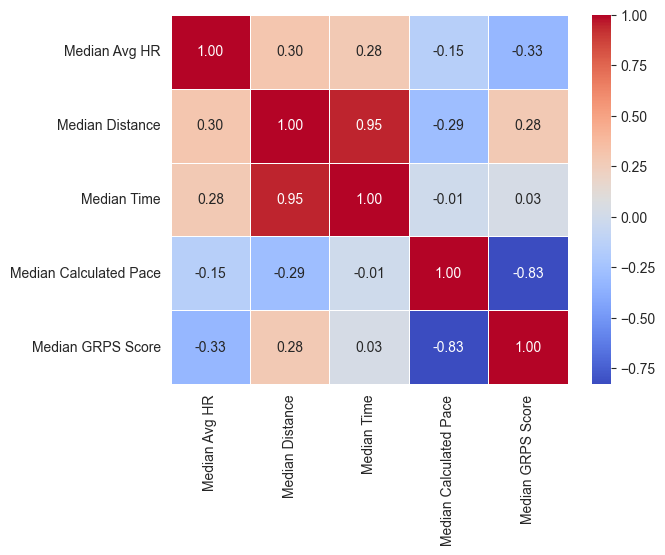

In [46]:
numeric_cols = final_df.select_dtypes(include=np.number)
corr_mat = numeric_cols.corr()
print("Correlation matrix between the data frame features")
print(sns.heatmap(corr_mat, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5))

Feature histogrms:



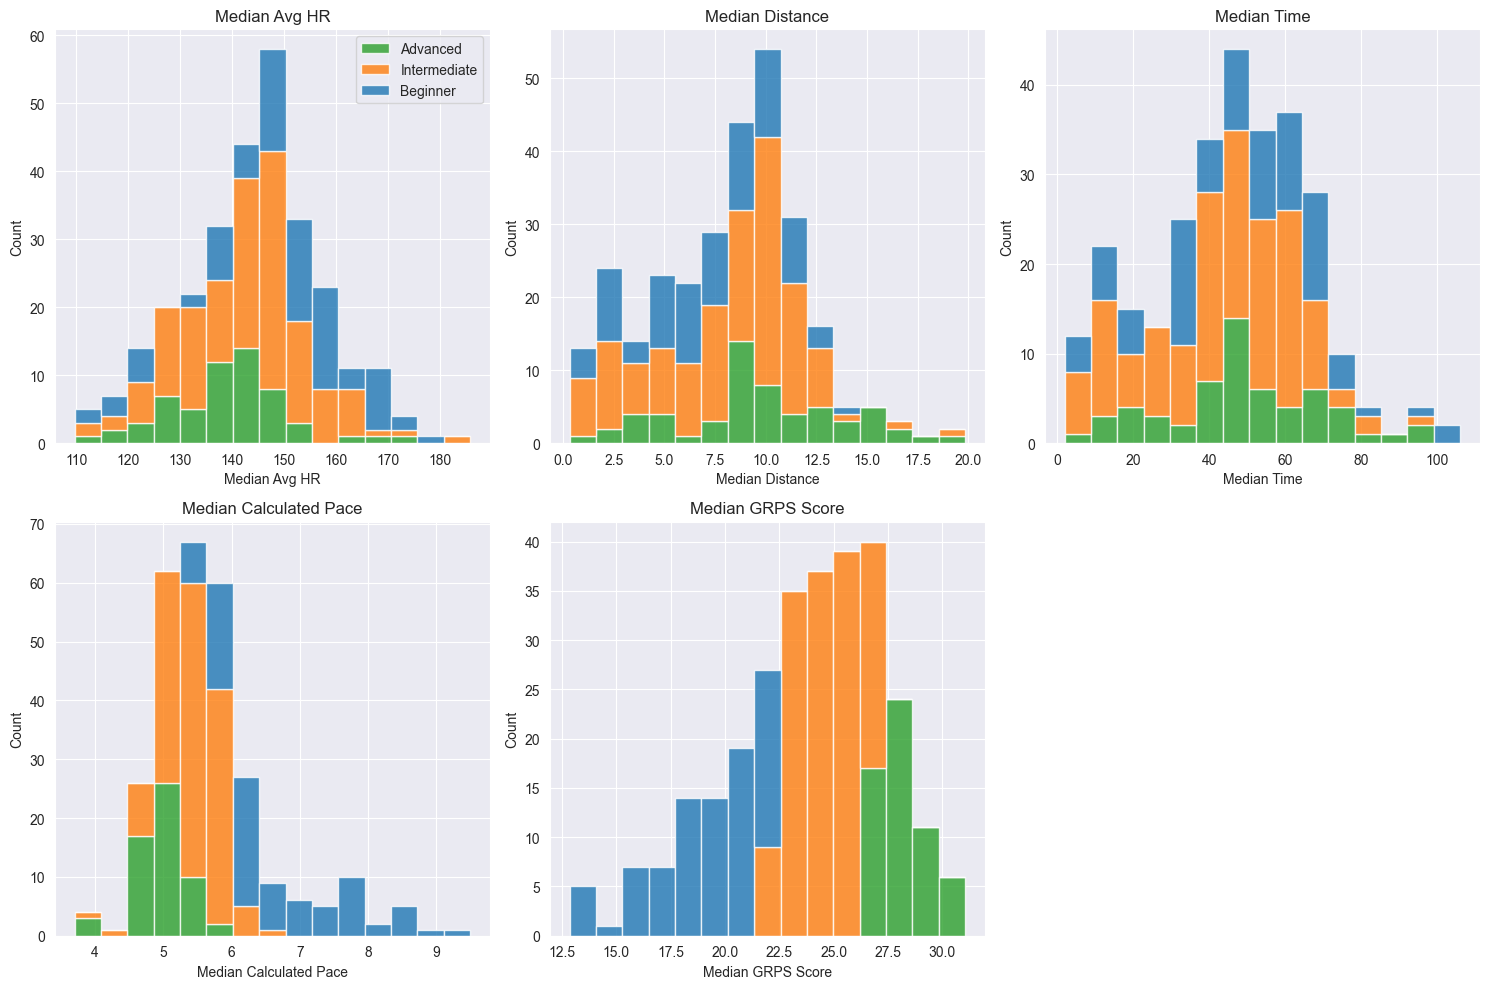

In [47]:
runner_classes = ["Advanced", "Intermediate", "Beginner"]
colors = ['tab:green', 'tab:orange', 'tab:blue']
labels = ['Advanced', 'Intermediate', 'Beginner']
numeric_cols = final_df.select_dtypes(include=np.number).columns.tolist()
num_plots = len(numeric_cols)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()
print("Feature histogrms:\n")
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    data = [final_df[final_df['Runner_Class'] == cls][col] for cls in runner_classes]
    ax.hist(data, bins=15, stacked=True, color=colors, label=labels, alpha=0.8)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    if i == 0:
        ax.legend()
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

**Exploring the features correlations: Distance, Calculated pace, avg HR in crossbreeding with Runner Class**  
I didn't use Median Time because it and Median Distance are extremly high correlated

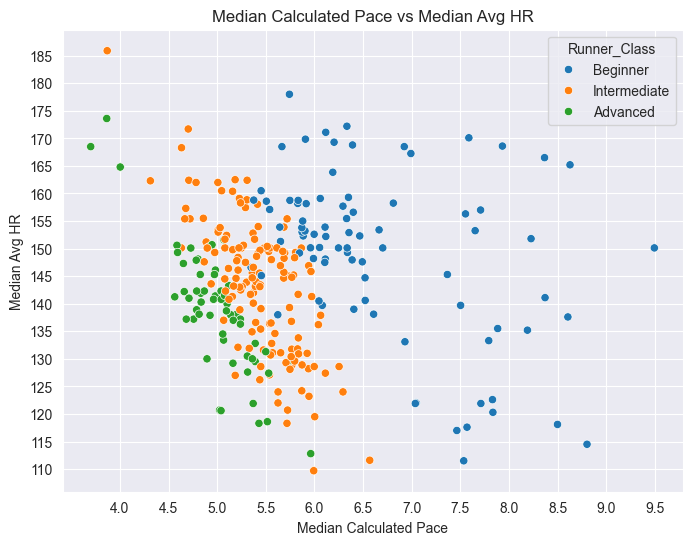

In [48]:
#Calculated Pace and Avg HR in correlation with Runner Class 
plt.figure(figsize=(8,6)) 
sns.scatterplot(data=final_df, x="Median Calculated Pace", y="Median Avg HR", hue = "Runner_Class" )
plt.title("Median Calculated Pace vs Median Avg HR")
plt.xlabel("Median Calculated Pace")
plt.ylabel("Median Avg HR")
tick_locations = np.arange(4, 10, 0.5)
tick_y_locations = np.arange(110,190,5)
plt.xticks(tick_locations)
plt.yticks(tick_y_locations)
plt.grid(True)
plt.show()

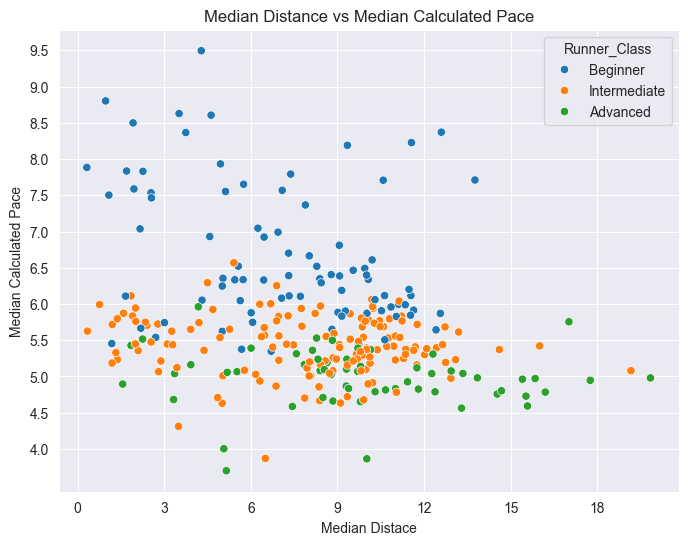

In [49]:
#Distance and Pace in correlation with Runner Class 
plt.figure(figsize=(8,6)) 
sns.scatterplot(data=final_df, x="Median Distance", y="Median Calculated Pace", hue = "Runner_Class" )
plt.title("Median Distance vs Median Calculated Pace")
plt.xlabel("Median Distace")
plt.ylabel("Median Calculated Pace")
tick_locations = np.arange(0, 21, 3)
tick_y_locations = np.arange(4,10,0.5)
plt.xticks(tick_locations)
plt.yticks(tick_y_locations)
plt.grid(True)
plt.show()

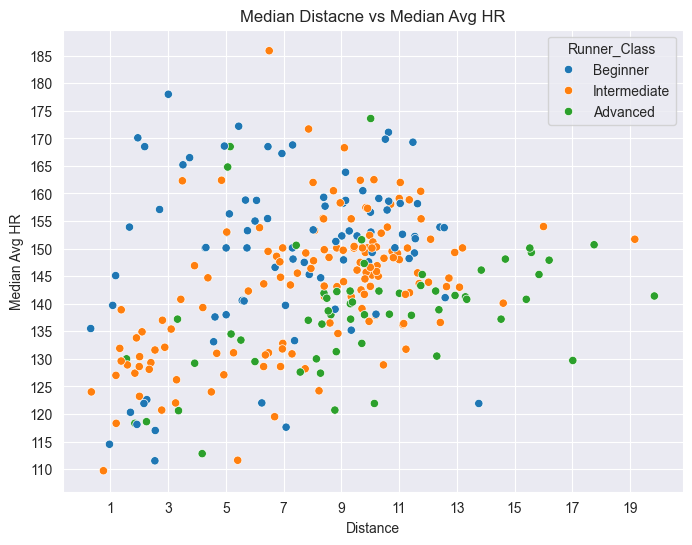

In [50]:
#Avg HR and Distacne in correlation with Runner Class
plt.figure(figsize=(8,6)) 
sns.scatterplot(data=final_df, x="Median Distance", y="Median Avg HR", hue = "Runner_Class" )
plt.title("Median Distacne vs Median Avg HR")
plt.xlabel("Distance")
plt.ylabel("Median Avg HR")
tick_locations = np.arange(1, 21, 2)
tick_y_locations = np.arange(110,190,5)
plt.xticks(tick_locations)
plt.yticks(tick_y_locations)
plt.grid(True)
plt.show()

**Data exploring conclusions**  
- We can see a very high correlation (0.95) between "Time" and "Distance." This strong relationship suggests we may only need to use one of these features in our models to avoid multicollinearity.  
- The absolute correlation between "GRPS" and "Calculated Pace" is the highest among all other features relative to "GRPS."  
- From the graphs above, it appears that "Calculated Pace" is the feature that most clearly separates the different classes. Other features like "Average HR," "Distance," and "Time" are more widely spread, with similar values across all classes. However, it's worth noting that specific regions of combined data (for example, "Calculated Pace" lower than 5.1 and "Distance" larger than 13) can still effectively characterize a class.

In [51]:
final_df.to_pickle("../data/processed_data.pkl")
print("Data saved successfully for classification.")

Data saved successfully for classification.
